In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

### Get Data

In [15]:
NUMERICAL_COLS = ()
CATEGORICAL_COLS = np.arange(22) + 1 # 1..22 inclusive

In [16]:
class DataTransformer:
    def fit(self, df):
        self.labelEncoders = {}
        self.scalers = {}
        
        # numerical
        for col in NUMERICAL_COLS:
            scaler = StandardScaler()
            scaler.fit(df[col].reshape(-1, 1))
            self.scalers[col] = scaler
            
        # categorical
        for col in CATEGORICAL_COLS:
            encoder = LabelEncoder()
            
            # in case the train set does not have 'missing value but test set does
            values = df[col].tolist()
            values.append('missing')
            encoder.fit(values)
            self.labelEncoders[col] = encoder
            
        # find dimensionality
        self.D = len(NUMERICAL_COLS)
        for col, encoder in self.labelEncoders.items():
            self.D += len(encoder.classes_)
        print("dimensionality: ", self.D)
        
    def transform(self, df):
        N, _ = df.shape
        X = np.zeros((N, self.D))
        i = 0
        
        # put data in X
        for col, scaler in self.scalers.items():
            X[:,i] = scaler.transform(df[col].as_matrix().reshape(-1, 1)).flatten()
            i += 1
        
        for col, encoder in self.labelEncoders.items():
            K = len(encoder.classes_)
            X[np.arange(N), encoder.transform(df[col]) + i] = 1
            i += K
        return X
    
    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

In [17]:
def get_data():
    df = pd.read_csv('./agaricus-lepiota.data.txt', header=None)
       
    # replace label column: e/p --> 0/1
    df[0] = df.apply(lambda row: 0 if row[0] =='e' else 1, axis=1)
    
    # transform data
    transformer = DataTransformer()
    
    X = transformer.fit_transform(df)
    Y = df[0].as_matrix()
    return X, Y

### 1. Adaboost

In [54]:
class AdaBoost:
    def __init__(self, M):
        self.M = M
        
    def fit(self, X, Y):
        self.models = []
        self.alphas = []
        
        N, _ = X.shape
        W = np.ones(N) / N # initialize sample weight
        
        for m in range(self.M):
            W = list(W)

            tree = DecisionTreeClassifier(max_depth=1) # weak learner
            tree.fit(X, Y, sample_weight=W)
            P = tree.predict(X) # vector
            
            W = np.array(W)
            err = W.dot(P != Y)
            alpha = 0.5 * (np. log(1 - err) - np.log(err))
            
            W = W * np.exp(-alpha * Y * P) # update only using alpha, Y, P
            W = W / W.sum() # normalize so it sums to 1
            
            self.models.append(tree)
            self.alphas.append(alpha)
            
    def predict(self, X):
        # Not like sklearn API
        # We want accuracy and exponential loss for plotting
        N, _ = X.shape
        FX = np.zeros(N)
        
        for alpha, tree in zip(self.alphas, self.models):
            FX += alpha * tree.predict(X)
        return np.sign(FX), FX
    
    def score(self, X, Y):
        P, FX = self.predict(X)
        L = np.exp(-Y*FX).mean()
        return np.mean(P == Y), L        

### Test

In [55]:
X, Y = get_data()
Y[Y == 0] = -1 # make the targets -1,+1
Ntrain = int(0.8*len(X))
Xtrain, Ytrain = X[:Ntrain], Y[:Ntrain]
Xtest, Ytest = X[Ntrain:], Y[Ntrain:]

T = 200
train_errors = np.empty(T)
test_losses = np.empty(T)
test_errors = np.empty(T)
for num_trees in range(T):
    if num_trees == 0:
        train_errors[num_trees] = None
        test_errors[num_trees] = None
        test_losses[num_trees] = None
        continue
    if num_trees % 20 == 0:
        print(num_trees)

    model = AdaBoost(num_trees)
    model.fit(Xtrain, Ytrain)
    acc, loss = model.score(Xtest, Ytest)
    acc_train, _ = model.score(Xtrain, Ytrain)
    train_errors[num_trees] = 1 - acc_train
    test_errors[num_trees] = 1 - acc
    test_losses[num_trees] = loss

dimensionality:  139
20
40
60
80
100
120
140
160
180


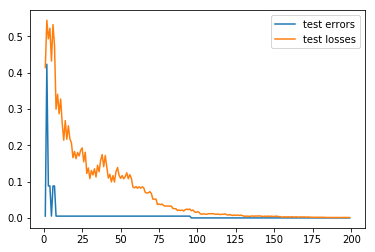

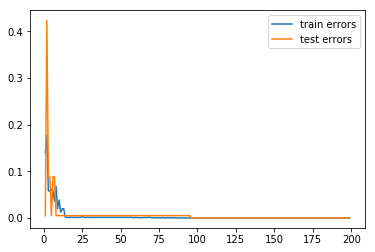

In [56]:
plt.plot(test_errors, label='test errors')
plt.plot(test_losses, label='test losses')
plt.legend()
plt.show()

plt.plot(train_errors, label='train errors')
plt.plot(test_errors, label='test errors')
plt.legend()
plt.show()

- Random Forest보다 좋은 결과이다.